In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde, TransformBoundedKDE
from pesummary.gw.plots.bounds import default_bounds
from scipy import stats

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
import gpflow
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from uncertainties import unumpy

from gp4gw.density.bounded_model import BoundedDensityModel
from gp4gw.density.data_preparation import *
from gp4gw.density.training_tools import *

import corner
from scipy.cluster.vq import kmeans2

# Loading posterior samples

In [2]:
data_path = "../pe_samples/GW150914_downsampled_posterior_samples.dat"

In [3]:
unscaled_data = pd.read_csv(data_path).sample(frac=1)

print("Posterior samples array: ", unscaled_data.shape)

Posterior samples array:  (50000, 42)


Slicing the posterior surface, we only want to interpolate over 2 dimensions

In [4]:
param_names = [
    "chirp_mass",
    "mass_ratio",
    "chi_p",
    "chi_eff",
]

# Evaluate density with histogram
* For computational reasons we only include non-zero bins

In [19]:
Nb = 15

bin_array = np.vstack(
    [
        np.linspace(unscaled_data[param].min(), unscaled_data[param].max(), Nb)
        for param in param_names
    ]
)

counts, bins = np.histogramdd(
    np.array(unscaled_data[param_names]), density=True, bins=bin_array
)

x = create_4d_data_set(bins)
y = counts.flatten()
print("Shape of bin counts:", y.shape)

print("Fraction of non-zero bins:",len(y[y > 0]) / len(y))

x_nonzero = x[y > 0]
y_nonzero = y[y > 0]

Shape of binning: (14, 4)
Histogram points: (38416, 4)
Shape of bin counts: (38416,)
Fraction of non-zero bins: 0.09279987505206164


# Scale dataset

In [6]:
x_scaled, y_scaled, x_scaler, y_scaler = scale_data(x_nonzero, y_nonzero)

X = tf.convert_to_tensor(x_scaled, dtype=tf.float64)
Y = tf.convert_to_tensor(y_scaled.reshape(-1, 1), dtype=tf.float64)

N, Q = X.shape
print(f"X_train shape: {N}, {Q}; Y_train shape: {Y.shape}")

Shape of x-data: N=3565, Q=4
X_train shape: 3565, 4; Y_train shape: (3565, 1)


# Build GP model

In [7]:
k1 = gpflow.kernels.RBF(lengthscales=[0.1] * len(param_names), variance=0.1)
k4 = gpflow.kernels.Matern12(lengthscales=[0.01] * len(param_names), variance=0.01)

kernel = k1*k4
M = 128

Z = kmeans2(X.numpy(), M, minit="points")[0]

model = gpflow.models.SGPR(
    (X, Y),
    kernel,
    inducing_variable=Z,
    noise_variance=1.01e-6,
    mean_function=gpflow.mean_functions.Constant(y_scaler.transform(np.zeros((1, 1)))),
)

In [8]:
adam_learning_rate = 0.1
nepochs = 200

lr = InverseTimeDecay(
    adam_learning_rate,
    decay_steps=int(nepochs / 4),
    decay_rate=1,
    staircase=False)

Epoch 10: LOSS (train) 2185706824.3729525
Epoch 20: LOSS (train) 2001501893.334865
Epoch 30: LOSS (train) 1603670069.9751732
Epoch 40: LOSS (train) 907328533.4449794
Epoch 50: LOSS (train) 530378508.6942875
Epoch 60: LOSS (train) 367557878.6706557
Epoch 70: LOSS (train) 272600972.6333173
Epoch 80: LOSS (train) 241357663.3392803
Epoch 90: LOSS (train) 223761122.2235902
Epoch 100: LOSS (train) 211858480.4801927
Epoch 110: LOSS (train) 203623819.32049385
Epoch 120: LOSS (train) 196545759.66398153
Epoch 130: LOSS (train) 189423138.45698258
Epoch 140: LOSS (train) 181518067.8226507
Epoch 150: LOSS (train) 171546723.03186417
Epoch 160: LOSS (train) 160200455.47049096
Epoch 170: LOSS (train) 151292476.73685408
Epoch 180: LOSS (train) 142113980.8867846
Epoch 190: LOSS (train) 126754812.62507023
Epoch 200: LOSS (train) 113810711.68509637
Training error: 0.0567971718643263
CPU times: user 1min 36s, sys: 19.9 s, total: 1min 56s
Wall time: 15.2 s


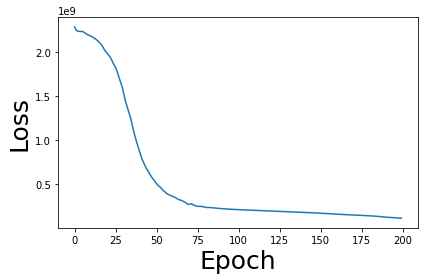

In [9]:
%%time
train_SGPR(
    model,
    optimizer=tf.keras.optimizers.Adam(lr),
    epochs=nepochs
)

print(
    f"Training error: {mean_squared_error(Y, model.predict_y(X)[0])}"  # , Testing error: {mean_squared_error(Y_test, model.predict_y(X_test)[0])}"
)

In [10]:
print(
    f"Training error: {mean_squared_error(Y, model.predict_f(X)[0])}"  # , Testing error: {mean_squared_error(Y_test, model.predict_y(X_test)[0])}"
)

Training error: 0.0567971718643263


# Sample Bounded model with HMC

In [12]:
%%time
mcmc_points = 3000
num_burnin = mcmc_points * 0.3
initialise_chains = np.mean(X, axis=0)

tight_priors = {
    param: tfp.distributions.Uniform(
        unscaled_data[param].min(), unscaled_data[param].max()
    )
    for param in param_names
}

density_model = BoundedDensityModel(
    likelihood=model.predict_f,
    param_names=param_names,
    priors=tight_priors,
    parameters_scaler=x_scaler,
    y_scaler=y_scaler,
)

num_chains = 10

print(f"mcmc_points: {mcmc_points}, num_burnin: {int(num_burnin)}")

print("Running chain..")
all_samples = density_model.sample_density(
    num_results=mcmc_points,
    num_burnin_steps=int(num_burnin),
    initialise_chains=initialise_chains + 1e-3 * np.random.randn(num_chains, X.shape[1]),
    sampler="HMC",
)

mcmc_points: 3000, num_burnin: 900
Running chain..
Instructions for updating:
The `step_size_update_fn` argument is deprecated. Use `tfp.mcmc.SimpleStepSizeAdaptation` instead.
Instructions for updating:
The `seed` argument is deprecated (but will work until removed). Pass seed to `tfp.mcmc.sample_chain` instead.
Running sampler with SimpleStepSizeAdaptation


/home/virginia.demilio/.conda/envs/gp4gw/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 5min 40s, sys: 78.9 ms, total: 5min 40s
Wall time: 5min 52s


In [13]:
az_data = convert_to_arviz_data(all_samples, x_scaler, param_names)

In [14]:
az.summary(az_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
chirp_mass,30.960,0.843,29.427,32.542,0.011,0.008,5850.0,9011.0,1.0
mass_ratio,0.860,0.091,0.698,1.000,0.001,0.001,6605.0,10090.0,1.0
chi_p,0.361,0.201,0.034,0.711,0.005,0.003,1544.0,1614.0,1.0
chi_eff,-0.040,0.064,-0.157,0.077,0.001,0.001,6267.0,9366.0,1.0


In [15]:
combine_chains = np.zeros((mcmc_points * num_chains, len(param_names)))
for i in range(len(param_names)):
    combine_chains[:, i] = all_samples[:, :, i].numpy().flatten()
gp_samples = x_scaler.inverse_transform(combine_chains)

az_data = convert_to_arviz_data(all_samples, x_scaler, param_names)


In [16]:
latex_param_names = [r"$\mathcal{M}$", r"$q$", r"$\chi_{\rm{p}}$", r"$\chi_{\rm{eff}}$"]

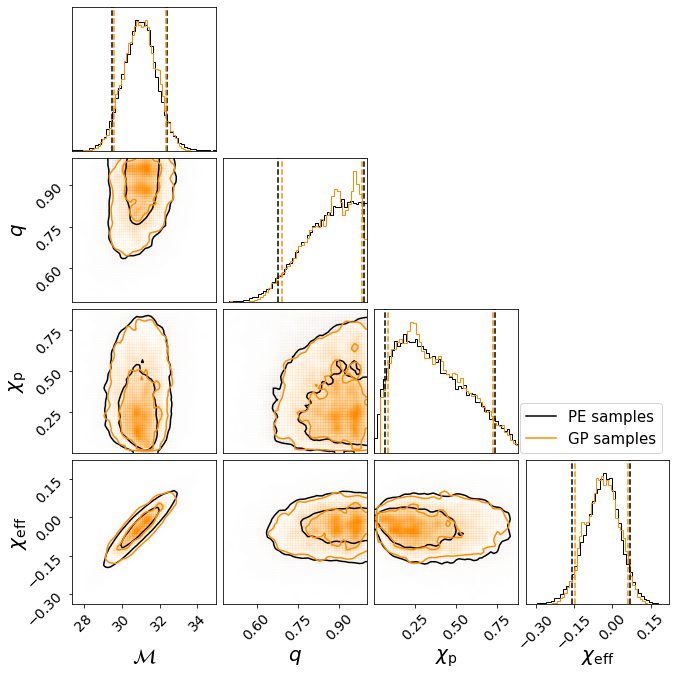

In [17]:
%matplotlib inline

blue_line = matplotlib.lines.Line2D([], [], color="k", label="PE samples")
red_line = matplotlib.lines.Line2D([], [], color="darkorange", label="GP samples")
fig1 = corner.corner(
    unscaled_data[param_names],
    bins=50,
    labels=latex_param_names,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    color="k",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig = corner.corner(
    gp_samples,
    fig=fig1,
    bins=50,
    plot_datapoints=False,
    fill_contours=False,
    plot_density=True,
    labels=latex_param_names,
    color="darkorange",
    smooth=0.9,
    levels = (0.50, 0.90),
    hist_kwargs={"density": True},
    quantiles=[0.05, 0.95],
    range=[0.9999] * len(param_names),
    max_n_ticks=4,
    label_kwargs=dict(fontsize=20),
)

fig.get_axes()[4].tick_params(which="major", bottom=False)
fig.get_axes()[5].tick_params(which="both", bottom=False)
fig.get_axes()[8].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", bottom=False)
fig.get_axes()[9].tick_params(which="both", left=False)
fig.get_axes()[10].tick_params(which="both", bottom=False)
fig.get_axes()[13].tick_params(which="both", left=False)
fig.get_axes()[14].tick_params(which="both", left=False)
fig.get_axes()[0].tick_params(which="both", bottom=False)

for ax in fig.get_axes():
    ax.tick_params(axis="both", labelsize=14)

plt.legend(
    handles=[blue_line, red_line],
    bbox_to_anchor=(0.0, 1.0, 1.0, 0.0),
    loc=4,
    fontsize=15,
)
# plt.savefig("./gp_intrinsic_4D.png", dpi=100)

In [18]:
for i, key in enumerate(param_names):
    print(key)
    print('GP: ', calc_mean_and_ci(gp_samples[:, i]).string)
    print('Pe: ', calc_mean_and_ci(unscaled_data[key]).string)

chirp_mass
GP:  ${30.97}_{-0.87}^{+0.87}$
Pe:  ${30.96}_{-0.89}^{+0.86}$
mass_ratio
GP:  ${0.87}_{-0.12}^{+0.08}$
Pe:  ${0.87}_{-0.12}^{+0.09}$
chi_p
GP:  ${0.33}_{-0.18}^{+0.26}$
Pe:  ${0.32}_{-0.19}^{+0.27}$
chi_eff
GP:  ${-0.04}_{-0.07}^{+0.07}$
Pe:  ${-0.04}_{-0.07}^{+0.06}$
